### This code covers: 

1. Output from Preprocess file created by Shivanshu is considered as input to this code. The preprocessing does not remove stop words. Hence stopwords removal TBD
2. Concated the columns containing text for ticket descrition. Merge "Title" & "Description" into "FullDescription". And used this column for further processing.
3. Extra column created for wordcounts in each document. We can use that for visualization.
4. Keras Tokenizer is used for word_index and text sequences
5. Used 200d word embeddings from Glove glove.6B.200d.txt. We can use 300d as well. Whichever we use we should keep it in our common repo
6. LSTM model - Accuracy - ~60% , Hyperparamter tuning yet to do ! Also try other models
7. WordCloud created for all the words of all documents. We can use this for visualization. We can further improved/augment it for per assignment group, to see which words are most frequently used for a ticket belonging to a particular group.

In [164]:
tf.__version__

'2.0.0'

In [165]:
import numpy as np
import pandas as pd


In [166]:
data = pd.read_csv("Preprocessed-Tickets.csv")

In [167]:
data.head()

,Title,Description,Caller,Assignment group
0,login issue,verified user details employee manager name ...,spxjnwir pjlcoqds,GRP_0
1,outlook,hello team meetings skype meetings etc are ...,hmjdrvpb komuaywn,GRP_0
2,cant log to vpn,cannot log to vpn best,eylqgodm ybqkwiam,GRP_0
3,unable access tool page,unable access tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [168]:
data.dtypes

Title               object
Description         object
Caller              object
Assignment group    object
dtype: object

In [169]:
data["Assignment group"].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
GRP_31      69
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_30      39
GRP_15      39
GRP_42      37
          ... 
GRP_36      15
GRP_44      15
GRP_50      14
GRP_65      11
GRP_53      11
GRP_52       9
GRP_55       8
GRP_51       8
GRP_59       6
GRP_49       6
GRP_46       6
GRP_43       5
GRP_66       4
GRP_32       4
GRP_38       3
GRP_56       3
GRP_63       3
GRP_58       3
GRP_68       3
GRP_69       2
GRP_54       2
GRP_57       2
GRP_72       2
GRP_71       2
GRP_35       1
GRP_73       1
GRP_64       1
GRP_67       1
GRP_61       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

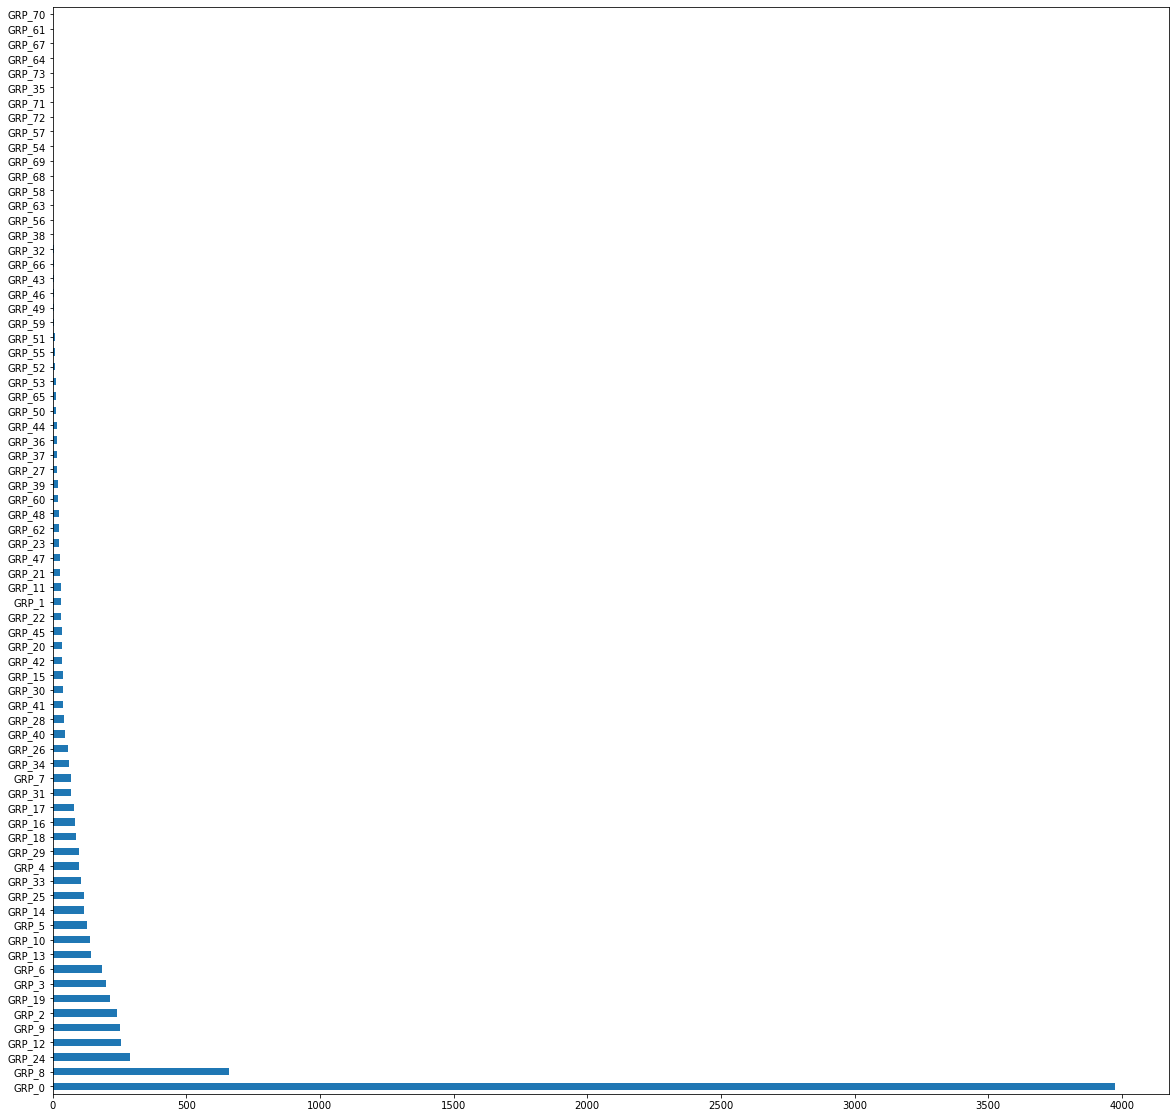

In [170]:
data['Assignment group'].value_counts().plot(kind='barh', figsize=(20,20))

### Q. Many of Assignment group have very less datapoints, hence difficult to train these classes. Should we discard  these classes or use Synthetic Data Generation methods like SMOTE to increase the datapoints for those classes ??

In [171]:
# Empty entries

(data.isna() == True).sum()

Title               8
Description         1
Caller              0
Assignment group    0
dtype: int64

In [172]:
data.fillna("", inplace=True)

### Q. Fill the empty column values with "" ??

In [173]:
#(pd.isna(data['Short description']) == True)

### Label Encode the Target Column

In [174]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data["Assignment group"])
y_classes_len = len(le.classes_)
le.classes_
print(y_classes_len)
data["Assignment group"] = le.transform(data["Assignment group"])
data.head()

74


,Title,Description,Caller,Assignment group
0,login issue,verified user details employee manager name ...,spxjnwir pjlcoqds,0
1,outlook,hello team meetings skype meetings etc are ...,hmjdrvpb komuaywn,0
2,cant log to vpn,cannot log to vpn best,eylqgodm ybqkwiam,0
3,unable access tool page,unable access tool page,xbkucsvz gcpydteq,0
4,skype error,skype error,owlgqjme qhcozdfx,0


### NLP Text Cleaning and Pre-Processing

In [175]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [176]:
# concat the two columns
data['FullDescription'] = data['Title'] + data['Description']

In [177]:
(pd.isna(data['FullDescription']) == True).sum()

0

In [178]:
all_documents = data["FullDescription"].values.tolist()

In [179]:
len(all_documents)

8500

In [180]:
all_documents

['login issue verified user details employee  manager name checked the user name ad and reset the password advised the user login and check caller confirmed that was able login issue resolved ',
 'outlook   hello team meetings skype meetings etc are not appearing my outlook calendar can somebody please advise how correct this kind ',
 'cant log to vpn   cannot log to vpn best ',
 'unable access tool pageunable access tool page',
 'skype error skype error ',
 'unable log to engineering tool and skypeunable log to engineering tool and skype',
 'event critical hostname  company com the value mountpoint threshold for oracle sid  erpdata  event critical hostname  company com the value mountpoint threshold for oracle sid  erpdata psa  psa data perpsr psa  ',
 'ticket employment status  new non employee enter user name ticket employment status  new non employee enter user name ',
 'unable disable add ins outlookunable disable add ins outlook',
 'ticket update inplant ticket update inplant ',


In [181]:
data['TicketWordCount'] = [len(desc.split(' ')) for desc in all_documents]
print("Max number of characters in a description", max([len(desc) for desc in all_documents]))
print("Max word count: ", data['TicketWordCount'].max())
print("Mean word count: ", data['TicketWordCount'].mean())

Max number of characters in a description 6902
Max word count:  1604
Mean word count:  34.357058823529414


In [182]:
data.head(10)

,Title,Description,Caller,Assignment group,FullDescription,TicketWordCount
0,login issue,verified user details employee manager name ...,spxjnwir pjlcoqds,0,login issue verified user details employee ma...,33
1,outlook,hello team meetings skype meetings etc are ...,hmjdrvpb komuaywn,0,outlook hello team meetings skype meetings e...,24
2,cant log to vpn,cannot log to vpn best,eylqgodm ybqkwiam,0,cant log to vpn cannot log to vpn best,12
3,unable access tool page,unable access tool page,xbkucsvz gcpydteq,0,unable access tool pageunable access tool page,7
4,skype error,skype error,owlgqjme qhcozdfx,0,skype error skype error,5
5,unable log to engineering tool and skype,unable log to engineering tool and skype,eflahbxn ltdgrvkz,0,unable log to engineering tool and skypeunable...,13
6,event critical hostname company com the value...,event critical hostname company com the value...,jyoqwxhz clhxsoqy,1,event critical hostname company com the value...,39
7,ticket employment status new non employee ent...,ticket employment status new non employee ent...,eqzibjhw ymebpoih,0,ticket employment status new non employee ent...,21
8,unable disable add ins outlook,unable disable add ins outlook,mdbegvct dbvichlg,0,unable disable add ins outlookunable disable a...,9
9,ticket update inplant,ticket update inplant,fumkcsji sarmtlhy,0,ticket update inplant ticket update inplant,7


In [183]:
max_ticket_desc_length = 300
embedding_dim = 200

In [184]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [185]:
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
#filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n\r0123456789'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_documents)

In [186]:
tokenizer_word_index = tokenizer.word_index

In [187]:
len(tokenizer_word_index)

15774

In [188]:
corpus_words = tokenizer_word_index.keys()

In [189]:
corpus_words

dict_keys(['the', 'job', 'not', 'and', 'for', 'password', 'please', 'yes', 'scheduler', 'erp', 'failed', 'tool', 'from', 'na', 'company', 'sid', 'this', 'user', 'access', 'reset', 'ticket', 'with', 'issue', 'unable', 'account', 'you', 'have', 'error', 'can', 'hostname', 'are', 'email', 'outlook', 'site', 'login', 'that', 'working', 'help', 'when', 'system', 'circuit', 'power', 'need', 'network', 'to', 'was', 'but', 'name', 'vendor', 'has', 'locked', 'hello', 'update', 'new', 'server', 'down', 'backup', 'able', 'engineering', 'out', 'all', 'telecom', 'usa', 'vpn', 'message', 'what', 'event', 'outage', 'phone', 'see', 'below', 'crm', 'windows', 'log', 'skype', 'type', 'will', 'printer', 'inside', 'team', 'request', 'does', 'number', 'your', 'plant', 'open', 'device', 'cannot', 'customer', 'is', 'since', 'get', 'mit', 'check', 'time', 'connect', 'change', 'et', 'manager', 'my', 'collaboration', 'management', 'best', 'f', 'microsoft', 'problem', 'contact', 'order', 'data', 'platform', 'com

In [190]:
X = tokenizer.texts_to_sequences(all_documents)

In [191]:
len(X)

8500

In [192]:
X = pad_sequences(X, maxlen = max_ticket_desc_length)
print(X)

[[    0     0     0 ...    35    23   289]
 [    0     0     0 ...   386    17   462]
 [    0     0     0 ...    45    64   103]
 ...
 [    0     0     0 ...     5  8097 15770]
 [    0     0     0 ...   639   314    44]
 [    0     0     0 ...  1177  3528  3073]]


In [193]:
y = np.asarray(data['Assignment group'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 8500
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

In [194]:
print(y)

[ 0  0  0 ...  0 59 44]


In [195]:
print(X.shape)
print(y.shape)

(8500, 300)
(8500,)


In [196]:
vocab_size = len(tokenizer_word_index) + 1 # 1 here is added to reserve padding
print("Vocabulary size : ", vocab_size)

Vocabulary size :  15775


### Creating word embeddings using Glove Embeddings

In [81]:
EMBEDDING_FILE = './glove.6B.200d.txt'

glove_embeddings = {}
for o in open(EMBEDDING_FILE, encoding="utf8"):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    glove_embeddings[word] = embd


In [82]:
print(len(glove_embeddings))

400000


### Create weight matrix for words in Ticket's Short description using Glove Embeddings

In [84]:
embedding_matrix = np.zeros((vocab_size, embedding_dim) )

In [85]:
for word, i in tokenizer_word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [86]:
embedding_matrix.shape

(15775, 200)

### Create and Compile Model

In [87]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [88]:
model = Sequential()

In [89]:
model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix]))

In [90]:
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.25))

In [91]:
model.add(Dense(y_classes_len, activation='softmax'))

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         3155000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 74)                2442      
Total params: 3,187,266
Trainable params: 3,187,266
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
import tensorflow as tf
y_labels = tf.keras.utils.to_categorical(y, y_classes_len)

batch_size = 32
epochs = 15

model.fit(X, y_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Train on 6800 samples, validate on 1700 samples
Epoch 1/15
6800/6800 [==============================] - 32s 5ms/sample - loss: 2.5740 - accuracy: 0.5010 - val_loss: 2.2980 - val_accuracy: 0.5024
Epoch 2/15
6800/6800 [==============================] - 30s 4ms/sample - loss: 1.9738 - accuracy: 0.5690 - val_loss: 2.0681 - val_accuracy: 0.5365
Epoch 3/15
6800/6800 [==============================] - 30s 4ms/sample - loss: 1.7457 - accuracy: 0.5843 - val_loss: 1.9433 - val_accuracy: 0.5459
Epoch 4/15
6800/6800 [==============================] - 30s 4ms/sample - loss: 1.5567 - accuracy: 0.6113 - val_loss: 1.8572 - val_accuracy: 0.5671
Epoch 5/15
6800/6800 [==============================] - 31s 4ms/sample - loss: 1.3890 - accuracy: 0.6449 - val_loss: 1.8052 - val_accuracy: 0.5888
Epoch 6/15
6800/6800 [==============================] - 32s 5ms/sample - loss: 1.2365 - accuracy: 0.6799 - val_loss: 1.7442 - val_accuracy: 0.5859
Epoch 7/15
6800/6800 [==============================] - 31s 5ms/sample

## Word Cloud

In [135]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [136]:
stopwords = set(STOPWORDS)

login issue verified user details employee  manager name checked the user name ad and reset the password advised the user login and check caller confirmed that was able login issue resolved 
33


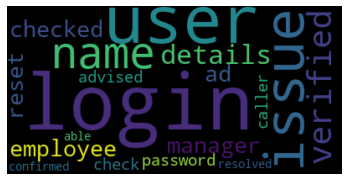

In [137]:
# Start with one review:
text = data.FullDescription[0]

print(text)
print(len(text.split(' ')))

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [157]:
# Try it create wordcloud for every assignemnt group to understand most used keywords for that group
# use groupby each assignment group

In [138]:
All_words = ""
All_words += " ".join(data.FullDescription)

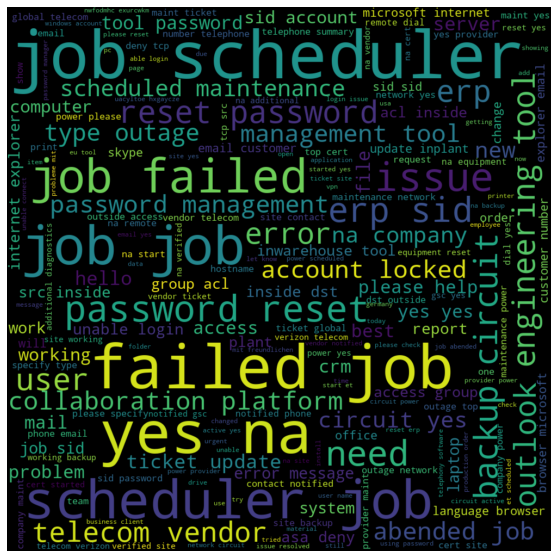

In [144]:
wordcloud = WordCloud(width=1000,height=1000,).generate(All_words) # width and height in the wordcloud attribute does not work
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

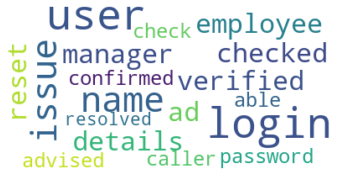

In [106]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [107]:
# Save the image in the img folder:
wordcloud.to_file("first_review.png")